### Classification Tasks


In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# splitting the data 
X,y = mnist["data"], mnist["target"]
y  = y.astype('uint8')

X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
# dig = X[0]
# img = dig.reshape(28,28)
# plt.imshow(img, cmap=mpl.cm.binary, interpolation='nearest')
# plt.axis("off")
# print('')

In [6]:
#Converting and training the problem for binary classifier
y_train_5 = (y_train==5)
y_test_5  = (y_test==5)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
some_digits = X_test[:100]
some_labels = y_test_5[:100]
some_labels_real = y_test[:100]
# preds = sgd_clf.predict(some_digits)

### Measuring Accuracy & Cross-Validation
Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

#### Confusion Matrix
Each row in a confusion matrix represents an actual class, while each column represents a predicted class

|--|Predicted FALSE|Predicted TRUE|
|--|-------------------------|------------------------|
|ACTUAL FALSE|False And Predicted False|False But Predicted True|
|ACTUAL TRUE|True But predicted False|True AND Predicted True|

__FORMALLY__:

|-|-|Predicted|-|
|-|-|--------------|----------------|
|-|-|Negative|Positive|
|Actual|Negative|True Negatives(TN)| False Positives(FP)|
|-|Positive|False Negatives(FN)| True Positives(TP)|

1. precision = $\frac{TP}{TP+FP}$

2. Recall, Sensitivity or True Positive Rate:
   
   recall = $\frac{TP}{TP+FN}$

**F1 Score**
* Metric that combines precision and recall into one
* It is the harmonic mean of precision and recall
* Regular mean treats all the values equally but harmonic mean gives more weight to low values.
* High F1 values when both precision and recall are high

$$F_{1} = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision+recall} = \frac{TP}{TP + \frac{FN+FP}{2}}$$

#### Characterstics
1. The F1 score favours classifiers having the similar values of precision and recall.

2. In some cases we prefer high precision such as censoring videos.

3. High recall where we don't mind false alarms. Such as shop-lifting detection etc.

4. Both cannot be increased simultaneously, its called *precision/recall tradeoff*

In [9]:
## Cross validation implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))
    

0.9669
0.91625
0.96785


In [3]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

NameError: name 'sgd_clf' is not defined

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Just like the ```cross_val_score()``` function, ```cross_val_predict()``` performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the prediction made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('precision score:',precision_score(y_train_5, y_train_pred))
print('recall score:', recall_score(y_train_5, y_train_pred))
print('f1 score:', f1_score(y_train_5, y_train_pred))

precision score: 0.8370879772350012
recall score: 0.6511713705958311
f1 score: 0.7325171197343846


In [13]:
y_scores = sgd_clf.decision_function(some_digits)
y_predsx = sgd_clf.predict(some_digits)

In [14]:
test_res_df=pd.DataFrame({'scores':y_scores, 'predicts':y_predsx, 'actual':some_labels})

In [15]:
test_res_df[test_res_df['predicts']==True]

,scores,predicts,actual
15,2609.524008,True,True
23,6474.066499,True,True
45,2197.350491,True,True
52,1794.587057,True,True
53,2452.784579,True,True
59,1774.666548,True,True
98,1483.461591,True,False


### Effect of changing the thresholds of the scores for prediction

$precision  = \frac{TP}{TP+FP}$, $recall = \frac{TP}{TP+FN}$

1. If the threshold is increased then by the formula above:
   
   a. False Positive: i.e. The values which are False but classified as True will decrease. Hence **PRECISION INCREASES**.
   
   b. False Negative: The values which are Not False but classified as false will increase because True values with lower scores will be ignored. Hence **RECALL DECREASES**
   
#### STRATEGIES for deciding the THRESHOLD values

1. Get scores of all instances in the training set using cross_val_predict() for deciding the threshold score


**NOTE**

$$Precision=\frac{Corretly Predicted Positive}{Total Predicted Positives}$$

----

$$Recall=\frac{Correctly Predicted Positive}{Actual Positives IN Dataset}$$

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

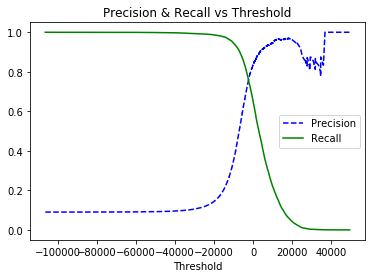

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlabel('Threshold')
plt.title('Precision & Recall vs Threshold')
plt.legend()
plt.show()

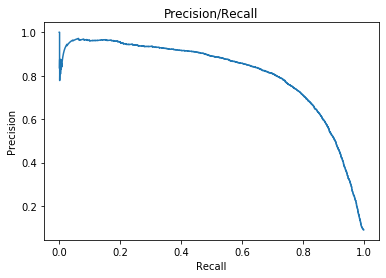

In [19]:
plt.plot(recalls,precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall')
plt.show()

#### Pit falls:
It might appear that if we want to create a model with any precision value by just setting up a high threshold.
E.g. From precision/recall we know that at 90% precision we have around 0.45 recall value, we can accoringly get the threshold at 


### The ROC Curve (Receiver Operating Characteristic)
It is a tool that is used with binary classifiers. It is a plot of `true positive rate(recall)` against the `false positive rate`.

**False Positive Rate(FPR)** = 1-true_negative_rate

The **FPR** is the ratio of negative instances that are incorrectly classified as positive.

**True Negative Rate(TNR)**: Ratio of negative instances that are correctly classified as negative. TNR is also called specificity.

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

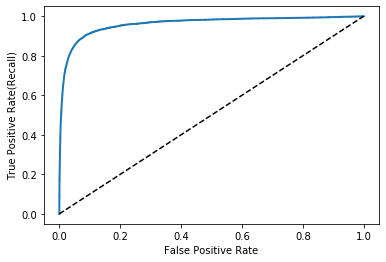

In [21]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate(Recall)')

plot_roc_curve(fpr, tpr)

The dotted line represents the ROC of a purely random classifier. 
A good classifier must stay as far as possible from this line.They are calculated at different thresholds and plotted against each other in the ROC Plot.

* AUC(Area Under Curve): The methods to measure the classifiers against each other is by comparing the `Area Under the Curve`(AUC) of the ROC of the two classifiers. 

In [22]:
# calculating the area under the curve:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As a rule of thumb, prefer the **PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives**, and the **ROC curve otherwise**.

*** In our case not sign/random article is being classified as them. I.E. The problem of FP(False Positive)

In [23]:
# training with RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=5, method = 'predict_proba')
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=5, method = 'predict_proba')

In [24]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

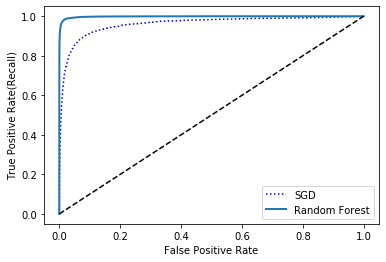

In [25]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()
plt.show()


In [26]:
y_results = cross_val_predict(forest_clf,X_train, y_train_5,cv=3)
#calculating its precision and recall


In [27]:
apply_padding = lambda x,y: x.ljust(len(x)+len(y)-len(x))
print(apply_padding('ROC_AUC Score','ROC_AUC Score'),':',roc_auc_score(y_train_5, y_scores_forest))
print(apply_padding('precision','ROC_AUC Score'),':',precision_score(y_train_5, y_results))
print(apply_padding('recall','ROC_AUC Score'),':', recall_score(y_train_5, y_results))
print(apply_padding('f1-score','ROC_AUC Score'),':', f1_score(y_train_5, y_results))

ROC_AUC Score : 0.998402186461512
precision     : 0.9905083315756169
recall        : 0.8662608374838591
f1-score      : 0.9242275142688446


### Multiclass Classification

*multiclass classifiers* or *multinomial classifiers* can distinguish between more than two classifiers.

Multiclass classification can be achieve with Binary classifiers also.
Types of classifying methods built from binary classifiers:

1. **One-Versus-All**: One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).


2. **One-Versus-One Strategy**: Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers.


** Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [28]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [29]:
preds = sgd_clf.predict(some_digits)
#pd.Series(some_labels_real).value_counts()
some_scores = sgd_clf.decision_function(some_digits)

In [30]:
#pd.DataFrame({'predicted':preds, 'ground_truths': some_labels_real})
np.argmax(some_scores, axis=1)


array([7, 2, 1, 0, 4, 1, 5, 1, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 5, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 3, 1, 1, 7, 9, 2,
       3, 5, 1, 2, 8, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 7, 7, 8, 9, 3, 7, 4,
       3, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9])

In the case of SGD we did't have to explicitly declare a 'OVA' type of the classifier, it automatically did the following:
1. It trained One-versus-all model for all the distinct classifiers.
2. Ran the test set on all the models
3. Calculates the argmax for all the Binary classifier.
4. Returns its label as a result.

For forcing the one-vs-one or one-vs-all use predefined classes:

In [31]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=45))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=45))

In [32]:
ovo_clf.predict(some_digits)
len(ovo_clf.estimators_)

45

These steps are not required for already multiclass classifiers.
For e.g. RandomForestClassifiers

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest_clf_rf = RandomForestClassifier()
forest_clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
cross_val_score(forest_clf_rf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96495, 0.9629 , 0.9669 ])

## General Approach Classification Training
Using grid search for turing **hyperparameters**.
This can be used to train/retrain until correct params are found.

#### RANDOM SEARCH VS GRID SEARCH
GridSearchCV function is used to simplify the process of hyperparameter tuning but it would be an extremely costly execution both in computing power and time.



In [35]:
from sklearn.model_selection import GridSearchCV

grid_parameters = [
    {'n_estimators':[10,50,100,125], 'criterion':["gini"], 'random_state':[42]},
    {'n_estimators':[50,100], 'max_depth':[10,30, 70,150], 'random_state':[42]},
    {'n_estimators':[100], 'min_samples_leaf':[1,2,4], 'min_samples_split':[2,5,10], 'random_state':[42]}
]

rfc = RandomForestClassifier()

gsearch = GridSearchCV(estimator= rfc, param_grid=grid_parameters, cv=3, verbose=2, n_jobs=2)

In [36]:
gsearch.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  63 out of  63 | elapsed:  7.3min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid=[{'criterion': ['gini'],
                          'n_estimators': [10, 50, 100, 125],
                          'random_state': [42]},
                         {'max_depth': [10, 30, 70, 150],
                          'n_estimators': [50, 100], 'random_state': [42]},
                         {'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [100], 'random_state': [42]}],
             verbose=2)

In [37]:
dir(gsearch)
gsearch.best_params_


{'criterion': 'gini', 'n_estimators': 125, 'random_state': 42}

In [64]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X_train_scaled = s.fit_transform(X_train)
rfc_opti = RandomForestClassifier(criterion='gini', n_estimators=125)
rfc_opti.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=125)

In [65]:
opti_preds_y = rfc_opti.predict(s.fit_transform(X_test))


In [66]:
#from sklearn.metrics import precision_score, recall_score, f1_score
xs = precision_score(y_test, opti_preds_y, average=None)


In [67]:
xs

array([0.95009785, 0.9929078 , 0.95744681, 0.94778325, 0.96843177,
       0.92596567, 0.9860515 , 0.9837233 , 0.93413174, 0.97010309])

In [59]:
precision_score(y_test, opti_preds_y, labels=[0,1,2,3,4,5,6,7,8,9],average=None)

array([0.97097097, 0.99204947, 0.95610687, 0.96428571, 0.97341513,
       0.96942242, 0.9760666 , 0.97249509, 0.96086509, 0.95908184])

### Error Analysis Multiclass

1. Confusion Matrix
Generate predictions for all the datapoints using the cross_val_predict.

In [69]:
from sklearn.metrics import confusion_matrix

y_train_preds = cross_val_predict(rfc_opti, X_train_scaled, y_train, cv=3)

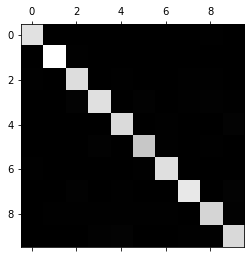

In [74]:
conf_mx = confusion_matrix(y_train,y_train_preds) #(rows,columns)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [81]:
res = np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3)
row_sum = res.sum(axis=1, keepdims=True) # all columns added
res/row_sum

array([[0.16666667, 0.33333333, 0.5       ],
       [0.26666667, 0.33333333, 0.4       ],
       [0.29166667, 0.33333333, 0.375     ]])

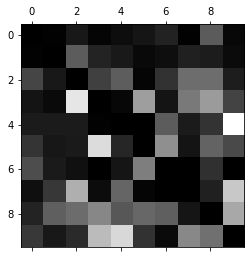

In [91]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx =conf_mx/row_sum
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# white color means relatively higher value

In [100]:
wrong_res_dict = {}

for i in range(10):
    wrong_res_dict[str(i)] = X_train[(y_train_preds!=y_train) & (y_train==i)]

In [103]:
wrong_res_dict['0']

(76, 784)

In [105]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

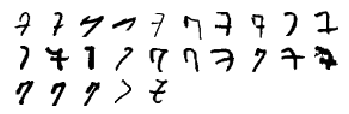

In [115]:
plot_digits(wrong_res_dict['7'][:25])

## Multilabel Classification

The classification system that outputs multiple binary tags  is called multilabel classification systems.

### EVALUATION OF MULTILABEL CLASSIFICATION
1. F1 Score: Calculate F1 score for all the labels individually, then compute their average.
Can be weighted in the circumstances where it is required.
e.g. When samples of a particular label is larger than others.

In [137]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = y_train>=7
y_train_odd = y_train%2 ==1
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

## Multioutput Classification
It is a generalization of multilabel classification where each label can be multiclass i.e. have more than two possible value.

e.g. 
The approach is simple we first add noise in the data and train the KNN to map the noisy image to the target image

In [155]:
# adding noise to image matrix by adding random ints

noise_train = np.random.randint(0, 100,X_train.shape)
X_train_mod = X_train+noise_train

noise_test = np.random.randint(0, 100,X_test.shape)
X_test_mod = X_test+noise_test

y_train_mod = X_train
y_test_mod = X_test

# plt.imshow(X_train_mod[:1].reshape((28,28)), mpl.cm.binary)
# plt.show()

# plt.imshow(y_train_mod[:1].reshape((28,28)), mpl.cm.binary)
# plt.show()

knn_class = KNeighborsClassifier()
knn_class.fit(X_train_mod, y_train_large)

KNeighborsClassifier()